module import

In [6]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import optuna
from functools import partial

load data

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
print(f'train size: {train.shape}')
print(f'test size: {test.shape}')

train size: (1460, 81)
test size: (1459, 80)


<h1>EDA</h1>

<h3>1. Exploring dependent variables</h3><br>
<h4>Outline</h4>
The dependent variable is a continuous variable. The goal is to solve the regression analysis problem.<br>
In order to improve the performance of the linear models, the dependent variables and residuals must satisfy <b>'normality'</b>.<br><br>

<h4>Normality</h4>
Normality means that the distribution of variables follows a normal distribution.<br>
The easiest way to test normality is to draw a histogram and a QQ plot.<br>
It is recommended that the histogram form a bell shape. It is good to understand to see skewness and kurtosis together.<br>
I thought that if skewness is between 0 and 0.5 and kurtosis is between 1 and 8, the shape of the histogram is similar to that of a bell.<br>
If there is a shape extending along the baseline to the top right in the QQ plot, we can see that the data has normality.<br><br>
If it violates normality, log transformation or boxcox transformation can be applied.

SalePrice's skew: 1.8828757597682129
SalePrice's kurt: 6.536281860064529


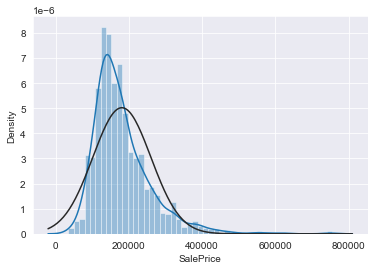

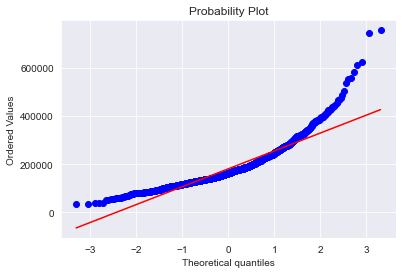

In [87]:
print(f"SalePrice's skew: {train.SalePrice.skew()}")
print(f"SalePrice's kurt: {train.SalePrice.kurt()}")
sns.distplot(train.SalePrice, fit=norm)
plt.show()
probplot(train.SalePrice, plot=plt)
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Because the histogram is skewed to the left (skewness > 0), and the points of the QQ plot are out of the baseline,<br>
    It is necessary to convert to satisfy normality through variable transformation such as log transformation.
</p>

Check whether there is a missing value of the dependent variable.

In [89]:
train.SalePrice.isnull().sum()

0

<h3 style="text-align:center;">2. Exploring independent variables - Define Type</h3><br>
<h4>Outline</h4>
<p>
    Variable search means reading data_description and determining type of variables.<br>
    We can read the description of the variable, determine the type of variable, and further derive ideas for generating derived variables and converting data.<br><br>
    The types of variables are classified as follows.<br>
    <ol>
        <li>Categorical</li>
        <ol>
            <li>Nominal vars</li>
            <li>Order(Rank) vars</li>
        </ol>
        <li>Continuous</li>
        <ol>
            <li>Interval vars</li>
            <li>Ratio vars</li>
        </ol>
    </ol>
    The method of searching and preprocessing is determined by the type of variable.<br>
    <br>
    By using Pandas, we can find out the data type (numerical type and object) of the variable.<br>
    However, not all numerical variables can be determined as continuous variables.<br>
    I divided them subjectively by referring to data_description.<br>
    <br>
    Criteria (subjective)
    <ol>
        <li>
            Nominal type: Not related by category or item.<br>
            ex) Country, type
        </li>
        <li>
            Rank (order) type: Rank, order, and comparison are possible for each category and item.<br>
            ex) Grade, quality, etc.
        </li>
        <li>
            Continuous: A numerical variable that can be expressed continuously in a real interval.<br>
            ex) Feet, number, etc.
        </li>
    </ol>
</p>

Check numerical and object variables.

In [14]:
num_vars = train.columns[train.dtypes != 'object']
obj_vars = train.columns[train.dtypes == 'object']

In [17]:
pd.DataFrame(num_vars, columns=['num vars']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
num vars,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


In [18]:
pd.DataFrame(obj_vars, columns=['obj vars']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
obj vars,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition


Explore some variables for example.<br><br>
<b>MSSubClass</b><br>
MSSubClass is a variable representing the type of residence.<br>
Although it is numerical, it is actually a categorical variable.<br>
I was able to read the description of each category in detail and find keywords representing 'order' like keywords such as 'Older' and 'Newer'.<br>
Therefore, MSSubClass was defined as an ordered variable.<br>
<br>
+Going further<br>
Looking at the description of MSSubClass, it can be seen that the category contains the following meanings.
1) Residential style.<br>
2) Years.<br>
3) The number of floors.<br><br>
The above items are all included in YearBuilt, HouseStyle, and BldgType, so they overlap.<br>
Instead, several categories have an additional meaning of 'PUD'.<br>
Therefore, it is possible to attempt to add a nominal derivative variable with a binary value based on PUD in the future.<br>
In addition, 1945 and 1946 often appear in explanations.<br>
Since this period may have an important domain meaning, it can be used when exploring YeaBuilt in the future.
<br><br>
<b>MSZoning</b><br>
MSZoning has a category. Each item is defined as a nominal variable because it does not have an order or ranking with each other.<br><br>
<b>LotFrontage</b><br>
LotFrontage is a continuous variable because it is a feet value.
<br><br>
<b>Street and Alley</b><br>
Street and Ally are nominal variables because there is no order and ranking.<br>
However, except for the NA value, They have Grvl or Pave. These variables are okay to be processed with ordered variables (applying label encoding instead of one hot encoding).<br><br>
+Going further<br>
Ally may have a negative meaning (NA) value.<br>
In the previous study, I learned that negative values can be recorded as missing values.<br>
Therefore, if there is a missing value, it can be directly replaced with a value such as None.
<br><br>
<b>OverallQual and OverallCond</b><br>
OverallQual and OverallCond are numerical but have categories.<br>
It can be seen that each item has a meaning related to quality. Therefore, it is a ranking variable.<br>
Ranked variables apply label encoding to preserve the meaning of values. However, there is no need to separately encode ranked variables that have already been expressed in sequential figures, such as 1 to 10.<br>
So I just included it in the continuous variable.
<br><br>
<b>ExterQual and ExterCond</b><br>
ExterQual and ExterCond are categories.
<br><br>
<b>BsmtFullBath and BsmtHalfBath</b><br>
In fact, the two variables commonly refer to the number of Bathrooms.<br>
I can think of creating a dataset with the same meaning as fewer variables by combining variables with one variable (ex) BsmtFullBath + 0.5 * BsmtHalfBath).
<br><br>
<b>Fence</b><br>
Fence is categorical and can be defined as a ranking variable because the item has a quality-related meaning.<br>
However, it is divided into a private case and a Wood case.<br>
Therefore, I can think that I can divide it into Privacy and Wood.
<br><br>
<b>MoSold and YrSold</b><br>
I treated variables such as YearBuild and YearEmodAdd as continuous variables.<br>
But when I checked the number of values in MoSold and YrSold (I used value_counts), the number of values were small enough to be treated as nominal variables.<br>
Therefore, the two variables were defined as nominal variables.<br><br>
I conducted the above search for all variables (if there is anything wrong or better idea, please comment).<br><br>
Now we can define the types of all variables.

In [63]:
nominal_vars = [
    'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 
    'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'MiscFeature',
    'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
]

In [64]:
order_vars = [
    'MSSubClass', 'Street', 'Alley', 'ExterQual', 'ExterCond', 'BsmtQual', 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'
]

In [72]:
continuous_vars = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

+After determining the types of all variables, I checked if there were any missing variables.<br><br>
I compared the number of columns in the training set with the sum of self-defined variables and found that the number was different(Except Id, SalePrice).<br>
I found in the data_description that the variables expressed in Bedroom and Kitchen are actually Bedroom AbvGr and Kitchen AbvGr. These were defined as continuous variables.

In [84]:
len(train.columns) == (len(nominal_vars) + len(order_vars)
                       + len(continuous_vars)) + len(set(['Id', 'SalePrice']))

True

<p>
    <font color='red'>Conclusion:</font><br>
    We defined the types of all variables.<br>
    This process can be effective in the pretreatment part later.
</p>

<h3>3. Exploring independent variables - Check the missing values</h3><br>
<h4>Outline</h4>
We need to make sure that missing values exist for all variables.<br>
isnull().Sum() can be used to find missing values.

In [92]:
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)
cnt_missing = all_data.isnull().sum().sort_values(ascending=False)
cnt_percent = cnt_missing / all_data.shape[0]
missing_table = pd.DataFrame([cnt_missing, cnt_percent], 
                             index=['missing count', 'missing percent']).T
missing_table = missing_table[missing_table['missing count'] > 0]

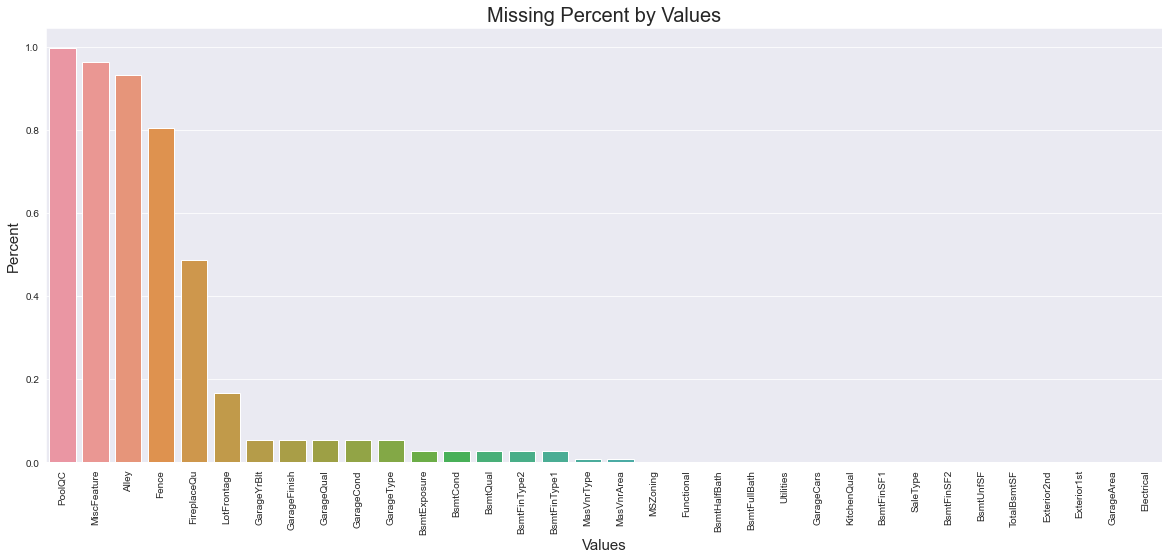

In [102]:
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x=missing_table.index, y=missing_table['missing percent'])
plt.title('Missing Percent by Values', size=20)
plt.xlabel('Values', size=15)
plt.ylabel('Percent', size=15)
plt.xticks(rotation='90')
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Many variables have missing values.<br>
    Some variables have extremely large amounts of missing values.<br>
    We previously found category variables with negative meanings.<br>
    Maybe we can handle them easily.
</p>

<h3>4. Bivariate search - correlation analysis, heat map, finding important variables</h3><br>
<h4>Outline</h4>
Correlation analysis is a technique to find out the correlation between the two variables.<br>
We can find variables with relatively strong <b>'linearity'</b> using the correlation coefficient with the dependent variable.<br>
I designated these variables as relatively important variables and tested <b>'homogeneity'</b>.<br>
In addition, I tested <b>'independence'</b> through the correlation between independent variables.<br>
<br>
<h4>Some assumptions for a good regression model</h4>
Previously, we checked the normality of the dependent variable and the residual.<br>
In addition, several more assumptions are needed.<br>
<ol>
    <li>
        <b>Linearity</b>:<br>
        It is recommended that the independent variable and the dependent variable have a linear relationship.<br>
        The 'variable transformation' or 'dimensional increase' method can help to have linearity.
    </li>
    <li>
        <b>homogeneity:</b>:<br>
        The variance of the residuals must be constant.<br>
        Drawing a residual diagram for an independent variable can test the equal variance.<br>
        If the points follow randomly based on the baseline, they satisfy the equal variance.
    </li>
    <li>
        <b>Independence</b>:<br>
        Independence means that there should be no correlation between independent variables.<br>
        The high correlation between independent variables causes multicollinearity. As a result, the performance of the model becomes incredible.
    </li>
    <li>
        <b>Irregularity</b>:<br>
        There should be no correlation between residuals.<br>
        Durbin-Watson' helps test for non-correlation.
    </li>
</ol>

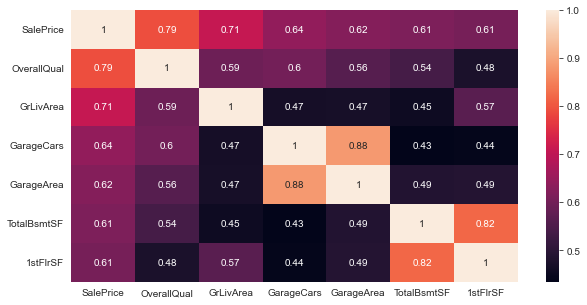

In [104]:
plt.subplots(figsize=(10, 5))
high_corr = train.corr().SalePrice.sort_values(ascending=False)[:7].index
sns.heatmap(train[high_corr].corr(), annot=True)
plt.show()

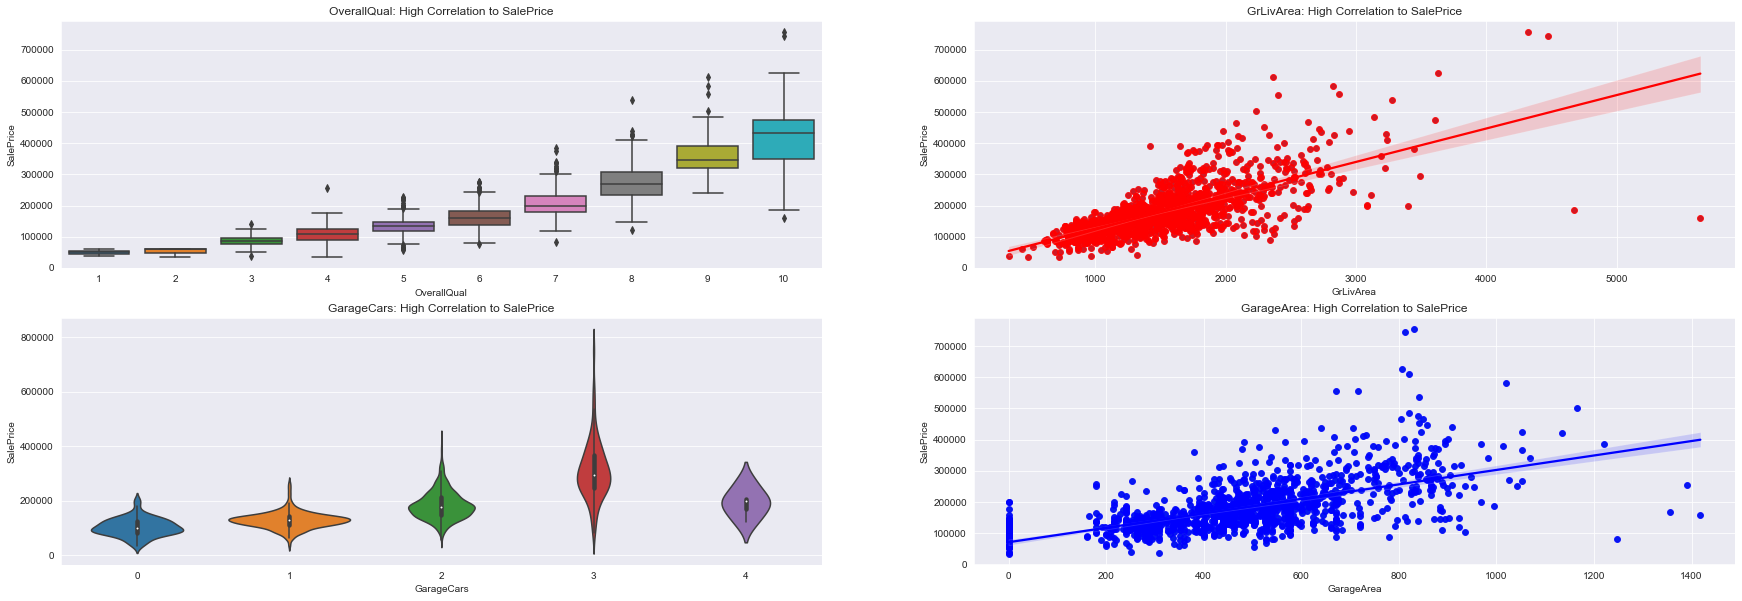

In [105]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(30, 10))
f1 = sns.boxplot(x=train.OverallQual, y=train.SalePrice, ax=ax1[0])
f1.set_title('OverallQual: High Correlation to SalePrice')

f2 = sns.scatterplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1[1])
sns.regplot(x=train.GrLivArea, y=train.SalePrice, color='r', ax=ax1[1])
f2.set_title('GrLivArea: High Correlation to SalePrice')

f2 = sns.violinplot(x=train.GarageCars, y=train.SalePrice, ax=ax2[0])
f2.set_title('GarageCars: High Correlation to SalePrice')

f2 = sns.scatterplot(x=train.GarageArea, y=train.SalePrice, ax=ax2[1])
sns.regplot(x=train.GarageArea, y=train.SalePrice, color='b', ax=ax2[1])
f2.set_title('GarageArea: High Correlation to SalePrice')
plt.show()

In [106]:
def chart_var(var):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    sns.distplot(train[var], fit=norm, ax=ax1)
    sns.residplot(x=train[var], y=train.SalePrice, ax=ax2)
    plt.show()
    probplot(train[var], plot=plt);

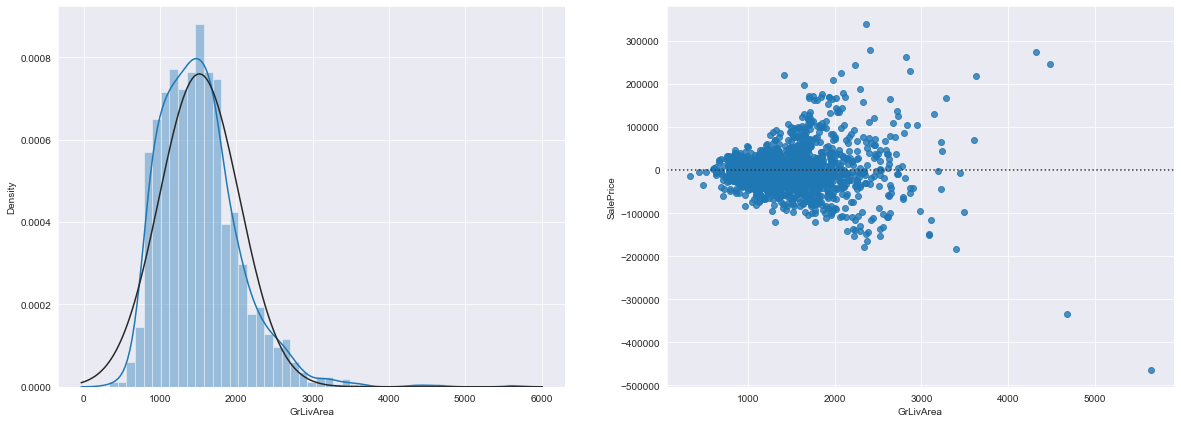

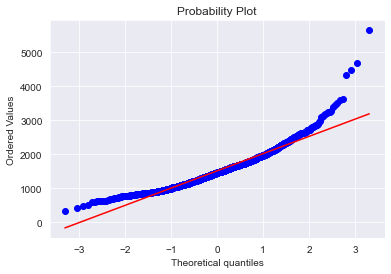

In [107]:
chart_var('GrLivArea')

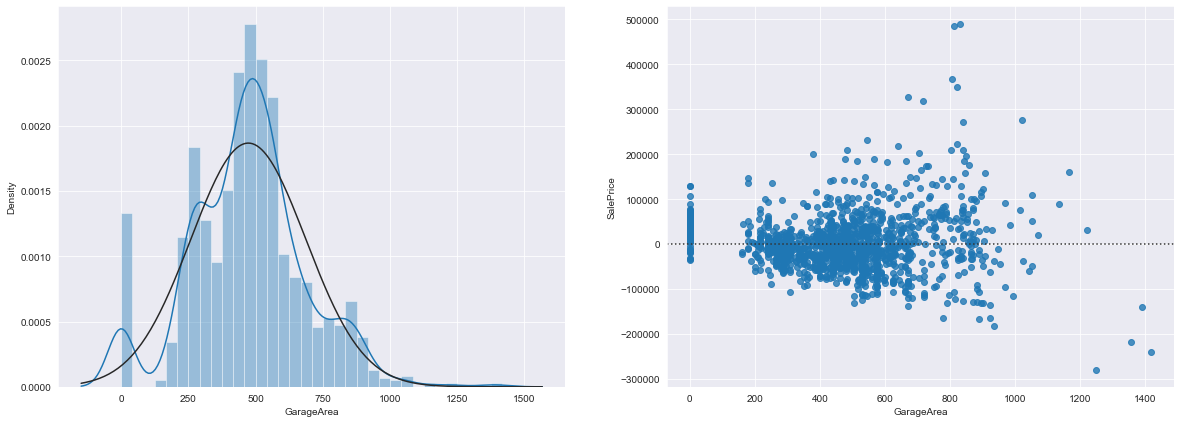

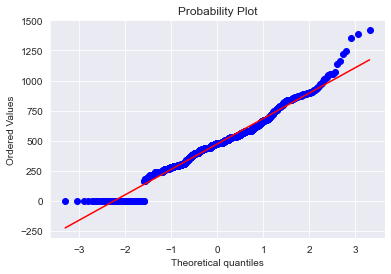

In [108]:
chart_var('GarageArea')